# Structured computations

Matrices that arise in applications often exhibit an identifiable *structure*. Even though some structures can be rather esoteric, we will be looking at some that are so common to have been given a name. And more importantly, we will see that some classes of matrices are so crucial in applications that the Basic Linear Algebra Subprograms (BLAS) library provides tailored implementations for them.

The structure can be easy to spot, for example as a distinctive *sparsity pattern*, that is, a pattern of zero and nonzero entries. Examples of this are banded matrices, whose nonzero elements can only appear in a narrow band along the main (north-west to south-east) diagonal, or triangular matrices, which must have zeros below (or above) the main diagonal.

In some cases, the structure underlying the matrix is not as easy to spot. Examples are low-rank matrices, or symmetric and Toeplitz matrices. In these cases, often we only become aware of the hidden structure because we know how the matrices have been generated.

Either way, what is most important to us, as developers of linear algebra algorithms, is that exploiting this structure in computation often pays off, because it allows us to develop more efficient and/or more accurate algorithms.

In this notebook, we will look at some examples of structured matrices and will try to develop some algorihtms for them. As we have only discussed matrix–vector and matrix–matrix multiplication, we will focus on developing efficient algorithms for these two operations. We will try to use some low level routines directly, and we will try to beat the structure-unaware built-in `numpy` function `@`. As we will see, this is extremely hard to achieve.

## Python packages
For this notebook we will be using `numpy`, as usual, but also three more packages:
+ `scipy`, which will allow us to access low-level routines from the [BLAS](https://docs.scipy.org/doc/scipy/reference/linalg.blas.html) and [LAPACK](https://docs.scipy.org/doc/scipy/reference/linalg.lapack.html) libraries;
+ `matplotlib`, which provides the neat [`matplotlib.pyplot.spy`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html) function to look at the sparsity pattern of a matrix; and
+ `timeit`, which provides the [`timeit.timeit`](https://docs.python.org/3/library/timeit.html) function to accurately time code snippets.

In [1]:
import numpy as np

import scipy as sp
from scipy import linalg

import matplotlib
from matplotlib import pyplot as plt

import timeit

## Triangular matrices

We will start with triangular matrices. A square $m$-by-$m$ matrix $A$ is
+ upper triangular if $a_{ij} = 0$ when $i > j$; and
+ lower triangular is $a_{ij} = 0$ when $i < j$.

**IMPORTANT:** Note that we only require that some elements be nonzero. Therefore, a diagonal matrix or the zero matrix are also upper and lower triangular, as they satisfy both  definitions above.

Today, we will focus on upper triangular matrices, but the case of lower triangular matrices is equivalent from a computational point of view.

First of all, let us implement a function that generates some upper triangular test matrices with random entries. There are two approaches to do this: we can generate a full matrix and then zero out the elements below the main diagonal, or we can start from an empty matrix and populate the nonzero elements.

**IMPORTANT:** In order to get efficient implementations when using for loops, it is crucial to access the elements of a matrix in the order in which they are stored in memory. The memory of the computer is linear, and therefore an $m$-by-$n$ matrix must be stored as a long vector of length $m \cdot n$. The elements can be stored:
+ in "column-major order": the matrix is stored one column after the other, from left to right; or
+ in "row-major order": the matrix is stored one row after the other, from top to bottom.

By default, NumPy uses row-major order, therefore accessing contiguous elements along a given row and moving from the end of one row to the beginning of the next will be efficient, while accessing elements along a column will incur a performance penalty. In summary, when using 2D `numpy` arrays you should always prefer an implementation that looks at rows rather than columns, if at all possible.

In [2]:
# Generate upper triangular matrices.
def generate_upper_triangular_matrix_add(m):
    """ Generate an m-by-m upper triangular matrix with random entries.
        This function generates an m-by-m zero matrix and then fills
        the upper triangular half with random entries.
    """
    #BEGIN SOLUTION
    C = np.zeros([m, m])
    for i in range(m):
        C[i,i:m] = np.random.rand(m-i)
    return C 
    #END SOLUTION

def generate_upper_triangular_matrix_remove(m):
    """ Generate an m-by-m upper triangular matrix with random entries.
        This function generates an m-by-m matrix with random entries
        before zeroing out the elements in the strictly lower
        triangular half.
    """
    #BEGIN SOLUTION
    C = np.random.rand(m, m)
    for i in range(1,m):
        C[i,0:i] = 0
    return C
    #END SOLUTION

def generate_upper_triangular_matrix_triu(m):
    """ Generate an m-by-m upper triangular matrix with random entries.
        This function generates an m-by-m matrix with random entries
        and then uses `np.triu()` to extract the upper triangular part.
        This is efficient for small `m`, but becomes very expensive for
        larger matrices as it requires the allocation of an additional
        `m`-by-`m` matrix.
    """
    return np.triu(np.random.rand(m, m))

As a sanity check, we can "spy" the matrices and confirm that in all three cases the sparsity pattern is what we expect.

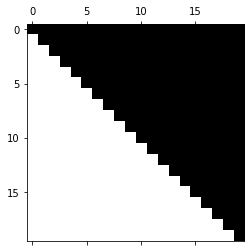

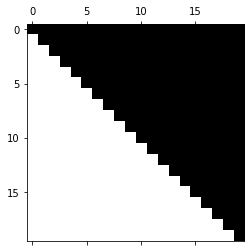

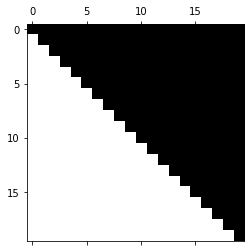

In [3]:
m = 20
plt.spy(generate_upper_triangular_matrix_add(m))
plt.show()
plt.spy(generate_upper_triangular_matrix_remove(m))
plt.show()
plt.spy(generate_upper_triangular_matrix_triu(m))
plt.show()

Next, we will compare the performance of the three functions by timing them and plotting the results in a log-log plot. Note how the function that is slowest for small matrices ($m < 100$) is the fastest for larger sizes. If the cell takes too long to run, you can just reduce the value of `n_reps` to 1. This will give you less accurate results but will be faster.

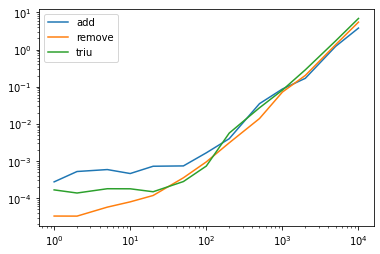

In [4]:
n_reps = 5 # Number of times the timing will be measured.
sizes = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
timings = np.zeros([sizes.size, 3])
for i in range(sizes.size):
    m = sizes[i]
    timings[i, 0] = timeit.timeit(lambda: generate_upper_triangular_matrix_add(m), number = n_reps)
    timings[i, 1] = timeit.timeit(lambda: generate_upper_triangular_matrix_remove(m), number = n_reps)
    timings[i, 2] = timeit.timeit(lambda: generate_upper_triangular_matrix_triu(m), number = n_reps)
plt.loglog(sizes, timings)
plt.legend(['add', 'remove', 'triu'])
plt.show()

Now we can try to implement a function that checks whether a matrix is upper triangular. Try to do it by rows and by columns, to see the difference in timings.


In [5]:
def is_upper_triangular_matrix_by_rows(A):
    """ Check if a matrix is upper triangular.
        It scans the matrix by rows.
    """
    #BEGIN SOLUTION
    (m, n) = A.shape
    if (m != n):
        return False
    for i in range(1, m):
        if any(A[i,0:i] != 0):
            return False
    return True
    #END SOLUTION
    
def is_upper_triangular_matrix_by_columns(A):
    """ Check if a matrix is upper triangular.
        It scans the matrix by columns.
    """
    #BEGIN SOLUTION
    (m, n) = A.shape
    if (m != n):
        return False
    for j in range(m-1):
        if any(A[j+1:m,j] != 0):
            return False
    return True
    #END SOLUTION

First of all, we want to check that the functions are correct. We can do this by taking a small upper triangular matrix and then adding an element that spoils the structure.

In [6]:
# Test some upper triangular matrices.
for m in range(1, 6):
    A = generate_upper_triangular_matrix_triu(m)
    if not is_upper_triangular_matrix_by_rows(A):
        raise Exception("Wrong result for `is_upper_triangular_matrix_by_rows(A)`")
    if not is_upper_triangular_matrix_by_columns(A):
        raise Exception("Wrong result for `is_upper_triangular_matrix_by_columns(A)`")

# Test some non-upper triangular matrices.
m = 5
for i in range (1, m):
    for j in range(i):
        A = generate_upper_triangular_matrix_triu(m)
        A[i, j] = 1
        if is_upper_triangular_matrix_by_rows(A):
            raise Exception("Wrong result for `is_upper_triangular_matrix_by_rows(A)`")
        if is_upper_triangular_matrix_by_columns(A):
            raise Exception("Wrong result for `is_upper_triangular_matrix_by_columns(A)`")

Now we can time the two functions and see which implemention is faster for small and large matrices.

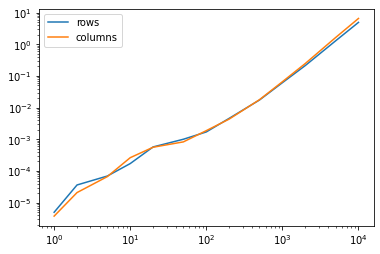

In [7]:
n_reps = 5 # Number of times the timing will be measured.
sizes = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
timings = np.zeros([sizes.size, 2])
### BEGIN SOLUTION
for i in range(sizes.size):
    m = sizes[i]
    A = generate_upper_triangular_matrix_add(m)
    timings[i, 0] = timeit.timeit(lambda: is_upper_triangular_matrix_by_rows(A), number = n_reps)
    timings[i, 1] = timeit.timeit(lambda: is_upper_triangular_matrix_by_columns(A), number = n_reps)
### END SOLUTION
plt.loglog(sizes, timings)
plt.legend(['rows', 'columns'])
plt.show()

You should see that for large enough values of $m$ the row-based solution is faster than the column-based alternative.

### Triangular matrix–vector multiplication

We will now try to implement algorithms for computing the action of an upper triangular matrix on a vector. The "action of the matrix $A$ on the vector $x$" is just another way of referring to the vector $Ax$. 

Given an upper triangular $m$-by-$m$ matrix $T$ and a vector $x$ of length $m$, the entries of the product $y = Tx$ can be computes as
\begin{equation*}
y_i = \sum_{j = i}^{m} t_{ij}x_{j}.
\end{equation*}


Try to implement this the usual three ways: naively using two for loops, and then more efficiently using inner and outer products. You can assume that the matrix $T$ is upper triangular—no need to check for this here. You can check that the matrix $T$ is square and that the dimensions of $T$ and $x$ are consistent. No need for fancy code, you can just use `assert`.

In [8]:
def compute_mxv_upper_triangular_naive(T, x):
    """ Compute the product Tx, where T is upper triangular.
        This function implements the formula using two loops.
    """
    ### BEGIN SOLUTION
    # Check shapes of T and x.
    (m, n) = T.shape
    assert(m == n)
    assert (x.shape[0] == n)
    if (x.ndim > 1):
        assert(x.ndim == 2 and x.shape[1] == 1)
    
    # Compute result.
    y = np.zeros_like(x)
    for i in range(m):
        for j in range(i, n):
            y[i] += T[i, j] * x[j]
    return y
    ### END SOLUTION
    
def compute_mxv_upper_triangular_with_inner_products(T, x):
    """ Compute the product Tx, where T is upper triangular.
        This function uses the inner product formulation.
    """
    ### BEGIN SOLUTION
    # Check shapes of T and x.
    (m, n) = T.shape
    assert(m == n)
    assert (x.shape[0] == n)
    if (x.ndim > 1):
        assert(x.ndim == 2 and x.shape[1] == 1)
    
    # Compute result.
    y = np.empty_like(x)
    for i in range(m):
        y[i] = np.dot(T[i, i:m], x[i:m])
    return y
    ### END SOLUTION
    
def compute_mxv_upper_triangular_with_outer_products(T, x):
    """ Compute the product Tx, where T is upper triangular.
        This function uses the outer product formulation.
    """
    ### BEGIN SOLUTION
    # Check shapes of T and x.
    (m, n) = T.shape
    assert(m == n)
    assert (x.shape[0] == n)
    if (x.ndim > 1):
        assert(x.ndim == 2 and x.shape[1] == 1)
    
    # Compute result.
    y = np.zeros_like(x)
    for j in range(n-1, -1, -1):
        y[0:j+1] += np.reshape(T[0:j+1, j] * x[j], y[0:j+1].shape)
    return y
    ### END SOLUTION

As usual, let us first look for obvious bugs by testing the functions. We will use `T @ x` as reference.


In [9]:
def compare_accuracy_triangular_mxv(m, f):
    """ Compare the result computed by the function `f`
        by the built-in operator `@`.
    """
    T = generate_upper_triangular_matrix_add(m)
    x = np.random.rand(m)
    if np.allclose(f(T, x), T @ x):
        return True
    else:
        print(x)
        print(f(T,x))
        return False

def run_sanity_check(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        takes an upper triangular matrix and a vector and
        computes their product.
    """
    for m in range(1, 5):
        assert(compare_accuracy_triangular_mxv(m, f))

f = compute_mxv_upper_triangular_naive
run_sanity_check(f)
f = compute_mxv_upper_triangular_with_inner_products
run_sanity_check(f)
f = compute_mxv_upper_triangular_with_outer_products
run_sanity_check(f)

Next, we should make sure that our code is exploiting the structure and not performing any unnecessary computation. In practice, this means avoiding all arithmetic operations whose result is known in advance: sums of zeros (the result is zero), sums where one of the operands is a zero (the result is the nonzero term), multiplications by one (the result is the other factor) or by zero (the result is zero), divisions by one (the result is the dividend), or division with 0 dividend (the result is zero).

One effective way to test for this is to perform the same test as above, but replacing the explicit zeros (or ones, if any, although this is not the case here) in the test matrix by the special floating-point value `numpy.nan` (not a number). As any arithmetic operation involving a `numpy.nan` will return a `numpy.nan`, the presence of a `numpy.nan` in the result will be evidence that the algorithm is performing some unnecessary computation. You can do this by modifying the `compare_accuracy_triangular_mxv` to pad the matrix `T` with `numpy.nan` before running the function `f`. You will have to compute the reference solution `T @ x` before padding, as the `@` function does not exploit the structure.

In [10]:
def compare_accuracy_triangular_mxv_with_nan(m, f):
    """ Compare the result computed by the function `f`
        by the built-in operator `@`.
    """
    ### BEGIN SOLUTION
    T = generate_upper_triangular_matrix_add(m)
    x = np.random.rand(m)
    reference = T @ x
    indices = np.tril_indices(m, -1)
    T[indices] = np.nan
    if np.allclose(f(T, x), reference):
        return True
    else:
        f(T, x)
        return False
    ### END SOLUTION

def run_sanity_check(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        takes an upper triangular matrix and a vector and
        computes their product.
    """
    for m in range(1, 5):
        for n in range(1, 5):
            for p in range(1, 5):
                assert(compare_accuracy_triangular_mxv_with_nan(m, f))

f = compute_mxv_upper_triangular_naive
run_sanity_check(f)
f = compute_mxv_upper_triangular_with_inner_products
run_sanity_check(f)
f = compute_mxv_upper_triangular_with_outer_products
run_sanity_check(f)

Now we can time these functions against the default `@`, which does not exploit the structure, and the `scipy.linalg.blas.dtrmv`, which computes the action of a triangular matrix on a vector by calling a low-level BLAS function that exploits the structure.

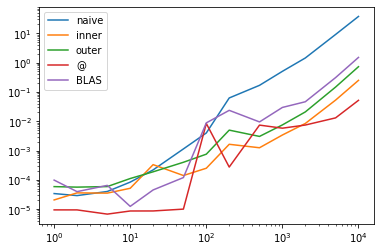

In [11]:
n_reps = 1 # Number of times the timing will be measured.
sizes = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
timings = np.zeros([sizes.size, 5])
for i in range(sizes.size):
    m = sizes[i]
    T = generate_upper_triangular_matrix_add(m)
    x = np.random.rand(m)
    timings[i, 0] = timeit.timeit(lambda: compute_mxv_upper_triangular_naive(T, x), number = n_reps)
    timings[i, 1] = timeit.timeit(lambda: compute_mxv_upper_triangular_with_inner_products(T, x), number = n_reps)
    timings[i, 2] = timeit.timeit(lambda: compute_mxv_upper_triangular_with_outer_products(T, x), number = n_reps)
    timings[i, 3] = timeit.timeit(lambda: T @ x, number = n_reps)
    timings[i, 4] = timeit.timeit(lambda: sp.linalg.blas.dtrmv(T, x), number = n_reps)
plt.loglog(sizes, timings)
plt.legend(['naive', 'inner', 'outer', '@', 'BLAS'])
plt.show()

You should clearly see the naive algorithm performing much worse than the other four. The timings of the other four algorithms should be closer.

### Triangular matrix–matrix multiplication

Next, we will try to implement a function that computes the product $D = TS$ where $T$ and $S$ are both $m$-by-$m$ upper triangular matrices. We can prove that in this case the usual formula for matrix multiplication gives
\begin{equation*}
    d_{ij} = 
    \begin{cases}
    \displaystyle\sum_{k = i}^{j} t_{ik} s_{kj},\quad &i \le j,\\
    0, \qquad &i > j.
    \end{cases}
\end{equation*}
Try to produce these three implementations: a three-loop naive one, a two-loop one based on inner products, and a single-loop one based on outer products. As in the previous section, you can assume that the matrices are both upper triangular, but you might want to check that $T$ and $S$ are square and conformable, for example using `assert`.

In [12]:
def compute_mxm_upper_triangular_naive(T, S):
    """ Compute the product TS, where T and S are upper triangular.
        This function implements the formula using three loops.
    """
    ### BEGIN SOLUTION
    if (T.shape != S.shape):
        raise Exception("Matrices are not conformable.")
    else:
        m = T.shape[0]

    D = np.zeros([m, m])
    for i in range(m):
        for j in range(m):
            for k in range (i, j+1):
                D[i,j] += T[i, k] * S[k, j]
    return D
    ### END SOLUTION
    
def compute_mxm_upper_triangular_with_inner_products(T, S):
    """ Compute the product TS, where T and S are upper triangular.
        This function implements the formula using inner products.
    """
    # BEGIN SOLUTION
    if (T.shape != S.shape):
        raise Exception("Matrices are not conformable.")
    else:
        m = T.shape[0]

    D = np.zeros([m, m])
    for i in range(m):
        for j in range(m):
            D[i,j] += T[i, i:j+1] @ S[i:j+1, j]
    return D
    ### END SOLUTION
    
def compute_mxm_upper_triangular_with_outer_products(T, S):
    """ Compute the product TS, where T and S are upper triangular.
        This function implements the formula using outer products.
    """
    # BEGIN SOLUTION
    if (T.shape != S.shape):
        raise Exception("Matrices are not conformable.")
    else:
        m = T.shape[0]

    D = np.zeros([m, m])
    for k in range(m):
            D[0:k+1, k:m] += np.outer(T[0:k+1, k], S[k, k:m])
    return D
    ### END SOLUTION

We can check test these three matrices directly on `numpy.nan`-padded matrices.

In [13]:
def compare_accuracy_triangular_mxv_with_nan(m, f):
    """ Compare the result computed by the function `f`
        by the built-in operator `@`.
    """
    ### BEGIN SOLUTION
    T = generate_upper_triangular_matrix_add(m)
    S =  generate_upper_triangular_matrix_add(m)
    reference = T @ S
    indices = np.tril_indices(m, -1)
    T[indices] = np.nan
    S[indices] = np.nan
    if np.allclose(f(T, S), reference):
        return True
    else:
        print(f(T,S))
        print(reference)
        return False
    ### END SOLUTION

def run_sanity_check(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        takes an upper triangular matrix and a vector and
        computes their product.
    """
    for m in range(1, 5):
        assert(compare_accuracy_triangular_mxv_with_nan(m, f))

f = compute_mxm_upper_triangular_naive
run_sanity_check(f)
f = compute_mxm_upper_triangular_with_inner_products
run_sanity_check(f)
f = compute_mxm_upper_triangular_with_outer_products
run_sanity_check(f)

For the timing, we can compare our two implementations (leaving out the naive three-loop one, which would be too slow) with the default `@` and with `scipy.linalg.blas.dtrmm`, which exploits the triangular structure of the first of the two matrices (the function computes $\alpha AB$ where $\alpha$ is a scalar and either $A$ or $B$ are either upper or lower triangular). 

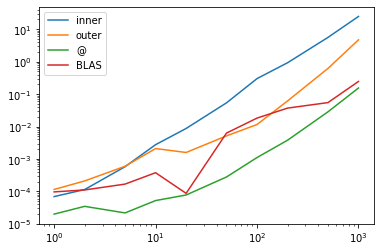

In [14]:
n_reps = 10 # Number of times the timing will be measured.
sizes = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
timings = np.zeros([sizes.size, 4])
for i in range(sizes.size):
    m = sizes[i]
    T = generate_upper_triangular_matrix_add(m)
    S = generate_upper_triangular_matrix_add(m)
    timings[i, 0] = timeit.timeit(lambda: compute_mxm_upper_triangular_with_inner_products(T, S), number = n_reps)
    timings[i, 1] = timeit.timeit(lambda: compute_mxm_upper_triangular_with_outer_products(T, S), number = n_reps)
    timings[i, 2] = timeit.timeit(lambda: T @ S, number = n_reps)
    timings[i, 3] = timeit.timeit(lambda: sp.linalg.blas.dtrmm(1, T, S), number = n_reps)
plt.loglog(sizes, timings)
plt.legend(['inner', 'outer', '@', 'BLAS'])
plt.show()

Once again, the function `@` seems hard to beat. This is not the case for larger values of $m$, however.

In [15]:
n_reps = 1
m = 10000
T = generate_upper_triangular_matrix_add(m)
S = generate_upper_triangular_matrix_add(m)
time_builtin = timeit.timeit(lambda: T @ S, number = n_reps)
time_dtrmm = timeit.timeit(lambda: sp.linalg.blas.dtrmm(1, T, S), number = n_reps)
print("Timing of @:     ", time_builtin)
print("Timing of dtrmm: ", time_dtrmm)

Timing of @:      10.085079544223845
Timing of dtrmm:  6.7574715949594975


## Hessenberg matrices

The upper triangular structure we have considered so far is one of the most fundamental ones, but the use of extremely optimised routines such as `scipy.linalg.blas.dtrmm` is not limited to the case of triangular matrices and can be useful when computing with other patterns as well. Take, for example, Hessenberg matrices. 

A square $m$-by-$m$ matrix $H$ is upper Hessenberg if $h_{ij} = 0$ when $i > j+1$. In other words, an upper Hessenberg matrix looks like an upper triangular matrix but has one additional diagonal of (potential) nonzero elements. This means that all upper triangular matrices are upper Hessenberg, but the opposite is not true in general.

Our final task is to implement a function to compute the matrix–matrix product $D = HA$, where $H$ is an $m$-by-$m$ upper Hessenmberg matrix and $A$ is an $m$-by-$m$ generic (no known structure) dense matrix. We want to go test the performance of this function on rather large matrices (order in the thousands), so the implementation should be as efficient as possible. You might want to use the formula
\begin{equation}
    d_{ij} = \sum_{k=i-1}^{m} h_{ik} a_{kj} = h_{i,i-1} a_{i-1,j} + \sum_{k=i}^{m} h_{ik} a_{kj},
\end{equation}
noticing that the second term in the sum is the formula for the product of *triangular* times *generic* matrix–matrix product. Your function should exploit this and use `scipy.linalg.blas.dtrmm`.

In [16]:
def generate_upper_hessenberg_matrix(m):
    """ Generate an m-by-m upper Hessenberg matrix with random entries.
        This function generates an m-by-m zero matrix and then fills
        the upper triangular half with random entries.
    """
    ### BEGIN SOLUTION
    C = np.zeros([m, m])
    C[0,:] = np.random.rand(m)
    for i in range(1, m):
        C[i,i-1:m] = np.random.rand(m-i+1)
    return C 
    ### END SOLUTION
    
def compute_mxm_upper_hessenberg_generic(H, A):
    """ Compute the product HA, where H is upper Hessenberg and A is generic.
        The function checks that the matrices are conformable, but does not
        check whether H is upper Hessenberg.
    """
    ### BEGIN SOLUTION
    (m, p) = H.shape
    (q, n) = A.shape
    if (p != q):
        raise Exception("Matrices are not conformable.")
    C = sp.linalg.blas.dtrmm(1, H, A)
    for i in range(m-1):
        C[i+1, :] += H[i+1, i] * A[i, :]
    ### END SOLUTION
    return C

As usual, we should start with a sanity check, to look for obvious bugs.

In [17]:
def compare_accuracy_upper_hessenberg_mxm_with_nan(m, f):
    """ Compare the result computed by the function `f`
        by the built-in operator `@`.
    """
    ### BEGIN SOLUTION
    H = generate_upper_hessenberg_matrix(m)
    A = np.random.rand(m, m)
    reference = H @ A
    indices = np.tril_indices(m, -2)
    H[indices] = np.nan
    if np.allclose(f(H, A), reference):
        return True
    else:
        print(f(H,A))
        print(reference)
        return False
    ### END SOLUTION

def run_sanity_check(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        takes an upper triangular matrix and a vector and
        computes their product.
    """
    for m in range(1, 10):
        for n in range(1, 10):
            for p in range(1, 10):
                assert(compare_accuracy_upper_hessenberg_mxm_with_nan(m, f))

f = compute_mxm_upper_hessenberg_generic
run_sanity_check(f)

This matrix–matrix multiplication algorithm was a difficult one to get right. If you have made it this far and your implementation passes the sanity check, you can—and indeed should—be very happy. This was a long and difficult notebook. We have only one thing left to look at—the highlight of this session: the timings.

In [18]:
m = 10000
H = generate_upper_hessenberg_matrix(m)
A = np.random.rand(m,m)
%time B = compute_mxm_upper_hessenberg_generic(H, A)
%time B = H @ A

CPU times: user 1min 27s, sys: 2.88 s, total: 1min 30s
Wall time: 6.34 s
CPU times: user 3min 45s, sys: 1min, total: 4min 45s
Wall time: 9.77 s


I hope that `compute_mxm_hessenberg_generic(H, A)` is faster than `H @ A` for you. It should be, if your implementation is the most efficient possible.